## Import libraries


In [1]:
import os
import warnings
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

warnings.filterwarnings("ignore")

WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/WBCrop"

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

## Read the data


In [2]:
file_paths = glob(os.path.join(WORK_DIR, "data", "raw", "crops", "*.csv"))

crop_samples_df = pd.DataFrame()

for path in file_paths:
    crop = os.path.basename(path).replace(".csv", "")
    crop_df = pd.read_csv(path)
    crop_samples_df = pd.concat((crop_samples_df, crop_df), axis=0, ignore_index=True)

# Create geometry column
geometry = [
    Point(x, y) for x, y in zip(crop_samples_df["long"], crop_samples_df["lat"])
]
crop_samples_gdf = gpd.GeoDataFrame(crop_samples_df, geometry=geometry, crs="EPSG:4326")

# Reproject to suitable projection
crs = "EPSG:32645"
crop_samples_gdf.to_crs(crs=crs, inplace=True)

print(crop_samples_gdf.shape)
crop_samples_gdf.head()

(45621, 12)


,sl,name,state,district,sowing,harvest,collection_date,season,pheno_stage,lat,long,geometry
0,1,others,west_bengal,nadia,nov_2023,march_2024,03/01/2024,rabi,mature,23.040170,88.548624,POINT (658671.805 2548805.951)
1,2,others,west_bengal,murshidabad,nov_2023,march_2024,03/01/2024,rabi,mature,24.055706,88.606017,POINT (663293.748 2661327.079)
2,3,others,west_bengal,murshidabad,nov_2023,march_2024,03/01/2024,rabi,mature,24.055959,88.606807,POINT (663373.692 2661355.974)
3,4,others,west_bengal,murshidabad,nov_2023,march_2024,03/01/2024,rabi,mature,24.056080,88.606749,POINT (663367.687 2661369.29)
4,5,others,west_bengal,murshidabad,nov_2023,march_2024,03/01/2024,rabi,mature,24.056154,88.606721,POINT (663364.736 2661377.465)


(24, 2)


<Axes: >

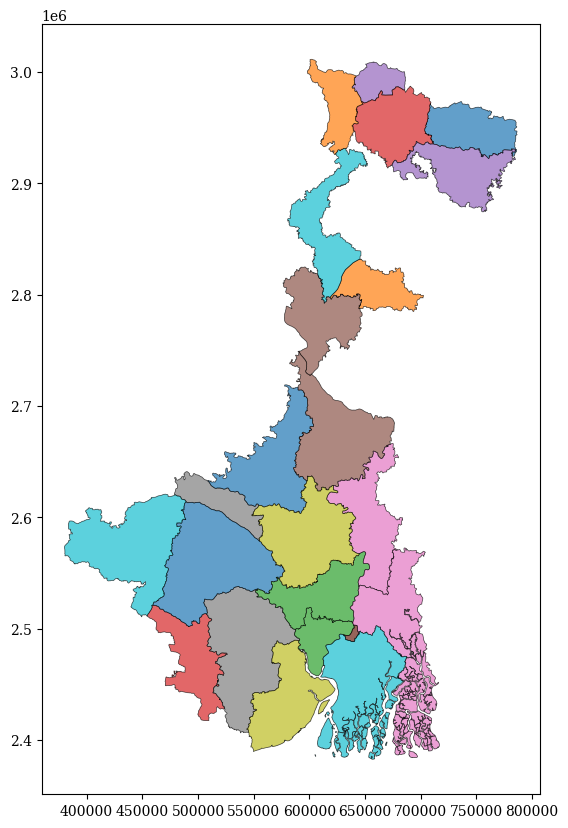

In [3]:
# Read the shapefile of West Bengal
wb_gdf = gpd.read_file(
    os.path.join(WORK_DIR, "data", "raw", "shapefile", "west_bengal.gpkg")
)
wb_gdf = wb_gdf[["Name", "geometry"]]
wb_gdf["Name"] = wb_gdf["Name"].str.lower()
wb_gdf.to_crs(crs=crs, inplace=True)

print(wb_gdf.shape)
wb_gdf.plot(column="Name", edgecolor="k", linewidth=0.5, figsize=(10, 10), alpha=0.7)

## Harmonize the data


### Harmonize the column name


In [4]:
# Harmonize the column name
crop_samples_harmonized = crop_samples_gdf.copy()
crop_samples_harmonized.rename(
    columns={"name": "crop", "lat": "latitude", "long": "longitude"}, inplace=True
)
crop_samples_harmonized.drop(columns="sl", inplace=True)

print("Name of the columns after processing:")
print(crop_samples_harmonized.columns)

Name of the columns after processing:
Index(['crop', 'state', 'district', 'sowing', 'harvest', 'collection_date',
       'season', 'pheno_stage', 'latitude', 'longitude', 'geometry'],
      dtype='object')


### Harmonize the crop name


In [5]:
# Harmonize the crop names
crop_samples_harmonized["crop"].replace(
    {
        "betel _leaf": "betel_leaf",
        "Pine Apple": "pine_apple",
        "aus-rice": "aus_rice",
        "KHESARI": "others",
        "TIL": "others",
    },
    inplace=True,
)
crop_samples_harmonized["crop"] = crop_samples_harmonized["crop"].str.lower()
print("Name of the unique crops after processing:")
print(crop_samples_harmonized["crop"].unique())

Name of the unique crops after processing:
['others' 'mustard' 'aman_rice' 'aus_rice' 'tea' 'sugarcane' 'groundnut'
 'pine_apple' 'betel_leaf' 'vegetables' 'jute' 'banana' 'boro_rice'
 'tobacco' 'potato' 'flower' 'wheat' 'maize']


### Harmonize the state name


In [6]:
# Fix the state name
crop_samples_harmonized["state"].replace({"west-bengal": "west_bengal"}, inplace=True)
print("Name of the state:", crop_samples_harmonized["state"].unique())

Name of the state: ['west_bengal']


### Harmonize the district name


In [7]:
crop_samples_harmonized = gpd.sjoin(
    left_df=crop_samples_harmonized,
    right_df=wb_gdf,
    how="inner",
    predicate="intersects",
)
crop_samples_harmonized.drop(columns=["index_right", "district"], inplace=True)
crop_samples_harmonized.rename(columns={"Name": "district"}, inplace=True)

print("Total number of district:", crop_samples_harmonized["district"].nunique())

print("Name of the unique districts after processing:")
print(np.sort(list(crop_samples_harmonized["district"].unique())))

Total number of district: 21
Name of the unique districts after processing:
['alipurduar' 'bankura' 'birbhum' 'dakshin dinajpur' 'darjiling' 'haora'
 'hugli' 'jalpaiguri' 'jhargram' 'koch bihar' 'maldah' 'murshidabad'
 'nadia' 'north 24 parganas' 'paschim barddhaman' 'pashchim medinipur'
 'purba barddhaman' 'purba medinipur' 'puruliya' 'south 24 parganas'
 'uttar dinajpur']


### Harmonize the sowing


In [8]:
print("Unique sowing values:")
print(crop_samples_harmonized["sowing"].unique())

Unique sowing values:
['nov_2023' 'oct_nov_2023' 'nov_dec_2023' 'july_2023' 'march_april_2024'
 'april_may_2023' 'feb-2023' 'feb_2024' 'march_2024' nan 'april_2023'
 'jan_2024' 'dec_jan_2024' 'dec_jan_2025' 'dec_jan_2026' 'dec_jan_2027'
 'dec_jan_2028' 'dec_jan_2029' 'dec_jan_2030' 'dec_jan_2031'
 'dec_jan_2032' 'dec_jan_2033' 'dec_jan_2034' 'dec_jan_2035'
 'dec_jan_2036' 'dec_jan_2037' 'dec_jan_2038' 'dec_jan_2039'
 'dec_jan_2040' 'dec_jan_2041' 'dec_jan_2042' 'dec_jan_2043'
 'dec_jan_2044' 'dec_jan_2045' 'dec_jan_2046' 'dec_jan_2047'
 'dec_jan_2048' 'dec_jan_2049' 'dec_jan_2050' 'dec_jan_2051'
 'dec_jan_2052' 'dec_jan_2053' 'dec_jan_2054' 'dec_jan_2055'
 'dec_jan_2056' 'dec_jan_2057' 'dec_jan_2058' 'dec_jan_2059'
 'dec_jan_2060' 'dec_jan_2061' 'dec_jan_2062' 'dec_jan_2063'
 'dec_jan_2064' 'dec_jan_2065' 'dec_jan_2066' 'dec_jan_2067'
 'dec_jan_2068' 'dec_jan_2069' 'dec_jan_2070' 'dec_jan_2071'
 'dec_jan_2072' 'dec_jan_2073' 'dec_jan_2074' 'dec_jan_2075'
 'dec_jan_2076' 'dec_jan_2077' 

In [9]:
mask = crop_samples_harmonized["sowing"].str.startswith("dec_jan_", na=False)
crop_samples_harmonized.loc[mask, "sowing"] = "dec_jan_2024"

sowing_map = {
    "july_2023": "jul_2023",
    "oct_nov_2023": "oct_nov_2023",
    "nov_dec_2023": "nov_dec_2023",
    "april_2023": "apr_2023",
    "nov_2023": "nov_2023",
    "april_may_2023": "apr_may_2023",
    "feb-2023": "feb_2023",
    "feb_2024": "feb_2024",
    "dec_2023": "dec_2023",
    "sept_oct_2023": "sep_oct_2023",
    "march_april_2024": "mar_apr_2024",
    "jan_2024": "jan_2024",
    "jan_feb_2024": "jan_feb_2024",
    "dec_jan_2024": "dec_jan_2024",
    "oct-2023": "oct_2023",
    "march_2024": "mar_2024",
    "feb_march_2023": "feb_mar_2023",
    "feb_march_2024": "feb_mar_2024",
}
crop_samples_harmonized["sowing"] = crop_samples_harmonized["sowing"].map(sowing_map)
print(crop_samples_harmonized.shape)

print("Unique sowing values after processing:")
print(crop_samples_harmonized["sowing"].unique())

(45616, 11)
Unique sowing values after processing:
['nov_2023' 'oct_nov_2023' 'nov_dec_2023' 'jul_2023' 'mar_apr_2024'
 'apr_may_2023' 'feb_2023' 'feb_2024' 'mar_2024' nan 'apr_2023' 'jan_2024'
 'dec_jan_2024' 'dec_2023' 'sep_oct_2023' 'jan_feb_2024' 'feb_mar_2024'
 'feb_mar_2023']


### Harmonize the harvest


In [10]:
print("Unique harvest values:")
print(crop_samples_harmonized["harvest"].unique())

Unique harvest values:
['march_2024' 'feb_march_2024' 'feb_mach_2024' 'nov_2023' 'june_july_2024'
 'feb_npv_2024' 'jan-feb_2024' 'june_2024' 'may_aug_2025'
 'may_august_2025' nan 'april_2024' 'aug-mid_sept_2023' 'august_2023'
 'may_2024' 'april_may_2024' 'feb_2024' 'dec_feb_2024'
 'mar_mid-april_2024' 'march_mid-april_2024' 'march_april_2024'
 'may_june_2024' 'may_june_2023']


In [11]:
harvest_map = {
    "feb_march_2024": "feb_mar_2024",
    "feb_mach_2024": "feb_mar_2024",
    "march_2024": "mar_2024",
    "nov_2023": "nov_2023",
    "june_july_2024": "jun_jul_2024",
    "jan-feb_2024": "jan_feb_2024",
    "may_aug_2025": "may_aug_2025",
    "may_august_2025": "may_aug_2025",
    "april_2024": "apr_2024",
    "aug-mid_sept_2023": "aug_sep_2023",
    "august_2023": "aug_2023",
    "may_2024": "may_2024",
    "april_may_2024": "apr_may_2024",
    "feb_2024": "feb_2024",
    "march-2024": "mar_2024",
    "april-2024": "apr_2024",
    "dec_feb_2024": "dec_feb_2024",
    "mar_mid-april_2024": "mar_apr_2024",
    "march_mid-april_2024": "mar_apr_2024",
    "march_april_2024": "mar_apr_2024",
    "may_june_2024": "may_jun_2024",
    "may_june_2023": "may_jun_2023",
    "feb_npv_2024": "feb_nov_2024",
    "june_2024": "jun_2024",
}
crop_samples_harmonized["harvest"] = crop_samples_harmonized["harvest"].map(harvest_map)

print("Unique harvest values after processing:")
print(crop_samples_harmonized["harvest"].unique())

Unique harvest values after processing:
['mar_2024' 'feb_mar_2024' 'nov_2023' 'jun_jul_2024' 'feb_nov_2024'
 'jan_feb_2024' 'jun_2024' 'may_aug_2025' nan 'apr_2024' 'aug_sep_2023'
 'aug_2023' 'may_2024' 'apr_may_2024' 'feb_2024' 'dec_feb_2024'
 'mar_apr_2024' 'may_jun_2024' 'may_jun_2023']


### Harmonize the collection date


In [12]:
print("Unique collection date:")
print(crop_samples_harmonized["collection_date"].unique())

Unique collection date:
['03/01/2024' '17/02/2024' '22/12/2023' '08-01-2024' '21/01/2024'
 '10-12-2023' '04-12-2023' '16-02-2024' '15/02/2024' '25-01-2024'
 'pod_formation' '11-12-2023' '07/02/2024' '06-01-2024' '08-12-2023'
 '09/12/2023' '30-08-2023' '31-08-2023' '05-10-2023' '01-09-2023'
 '08-11-2023' '16-10-2023' '26-09-2023' '18-10-2023' '20-09-2023'
 '05-09-2023' '26-10-2023' '29-08-2023' '12-10-2023' '28-08-2023'
 '02-09-2023' 'may_2024' '18/04/2024' '20/04/2024' '17/04/2024'
 '16/04/2024' '19/04/2024' '30/08/2023' '01/09/2023' '28/08/2023'
 '29/08/2023' '17-04-2024' '19-04-2024' '16-04-2024' nan '29/12/2023'
 '18/12/2023' '20-03-2023' '22-03-2023' '20/12/2023' '14-01-2024'
 '10-02-2024' '14/02/2024' '14-04-2024' '13/02/2024' '11/02/2024'
 '19/12/2023' '14/01/2024' '02/09/2023' '14/06/2024' '19/08/2023'
 '21/08/2024' '20-08-2023' '16/06/2024' '12/06/2024' '15-01-2023'
 '11-08-2023' '10-01-2023' '18-05-2024' '25-08-2023' '05-04-2024'
 '22-02-2024' '15-03-2024' '18/0/2024' '26-01-2

In [13]:
crop_samples_harmonized["collection_date"].unique()

crop_samples_harmonized["collection_date"] = crop_samples_harmonized[
    "collection_date"
].astype(str)

# Normalize separators
crop_samples_harmonized["collection_date"] = crop_samples_harmonized[
    "collection_date"
].str.replace("-", "/", regex=False)

# Convert to datetime (invalid values → NaT)
crop_samples_harmonized["collection_date"] = pd.to_datetime(
    crop_samples_harmonized["collection_date"], dayfirst=True, errors="coerce"
)

crop_samples_harmonized["collection_date"] = crop_samples_harmonized[
    "collection_date"
].dt.strftime("%Y-%m-%d")

print("Unique collection date after processing:")
print(crop_samples_harmonized["collection_date"].unique())

Unique collection date after processing:
['2024-01-03' '2024-02-17' '2023-12-22' '2024-01-08' '2024-01-21'
 '2023-12-10' '2023-12-04' '2024-02-16' '2024-02-15' '2024-01-25' nan
 '2023-12-11' '2024-02-07' '2024-01-06' '2023-12-08' '2023-12-09'
 '2023-08-30' '2023-08-31' '2023-10-05' '2023-09-01' '2023-11-08'
 '2023-10-16' '2023-09-26' '2023-10-18' '2023-09-20' '2023-09-05'
 '2023-10-26' '2023-08-29' '2023-10-12' '2023-08-28' '2023-09-02'
 '2024-04-18' '2024-04-20' '2024-04-17' '2024-04-16' '2024-04-19'
 '2023-12-29' '2023-12-18' '2023-03-20' '2023-03-22' '2023-12-20'
 '2024-01-14' '2024-02-10' '2024-02-14' '2024-04-14' '2024-02-13'
 '2024-02-11' '2023-12-19' '2024-06-14' '2023-08-19' '2024-08-21'
 '2023-08-20' '2024-06-16' '2024-06-12' '2023-01-15' '2023-08-11'
 '2023-01-10' '2024-05-18' '2023-08-25' '2024-04-05' '2024-02-22'
 '2024-03-15' '2024-01-26' '2024-02-18' '2024-02-28' '2024-03-11'
 '2024-04-10' '2024-03-21' '2024-02-19' '2024-01-27' '2024-01-18'
 '2024-01-22' '2024-01-20' '202

### Harmonize the season


In [14]:
print("Unique harmonized seasons:")
print(crop_samples_harmonized["season"].unique())

Unique harmonized seasons:
['rabi' 'frabi' 'aman/kharif' 'aus' 'annual' 'summer/zaid' '15-18_months'
 'kharif' 'boro' nan 'late_rabi/zaid/aus' 'late_rabi' 'Aus/summer'
 'aus/summer']


In [15]:
crop_samples_harmonized["season"] = (
    crop_samples_harmonized["season"].str.lower().str.strip()
)

season_map = {
    "rabi": "rabi",
    "frabi": "rabi",
    "late_rabi": "rabi",
    "aman/kharif": "kharif",
    "kharif": "kharif",
    "aus": "aus",
    "aus/summer": "aus",
    "aus/summer": "aus",
    "summer/zaid": "zaid",
    "late_rabi/zaid/aus": "rabi",
    "boro": "boro",
    "annual": "annual",
    "15-18_months": "annual",
}

crop_samples_harmonized["season"] = crop_samples_harmonized["season"].replace(
    season_map
)

print("Unique harmonized seasons after processing:")
print(crop_samples_harmonized["season"].unique())

Unique harmonized seasons after processing:
['rabi' 'kharif' 'aus' 'annual' 'zaid' 'boro' nan]


## Harmonize pheno stage


In [16]:
print("Unique phenological stages:")
print(crop_samples_harmonized["pheno_stage"].unique())

Unique phenological stages:
['mature' 'flowering' 'flowering_and_pod-formation' 'maturity'
 'pod_formation' '29/01/2024' 'vegetative' 'tillering' 'elongation'
 'tillering_and_elongation' 'maturation' 'booting_and_heading' 'heading'
 'booting' 'dough' 'seedling_and_tillering' 'growing' nan
 'onion_tillering' 'sowing' 'harvesting' 'harvesing' 'showing' 'seedling'
 'Tuber_Bulking' 'Tuber_Initiation' 'V-Tassel']


In [17]:
crop_samples_harmonized["pheno_stage"] = (
    crop_samples_harmonized["pheno_stage"].str.lower().str.strip()
)

crop_samples_harmonized.loc[
    crop_samples_harmonized["pheno_stage"].str.contains(r"\d{2}/\d{2}/\d{4}", na=False),
    "pheno_stage",
] = np.nan

pheno_map = {
    # Sowing
    "sowing": "sowing",
    "showing": "sowing",
    # Emergence / Early
    "seedling": "emergence",
    "seedling_and_tillering": "vegetative",
    # Vegetative
    "vegetative": "vegetative",
    "tillering": "vegetative",
    "elongation": "vegetative",
    "growing": "vegetative",
    "tillering_and_elongation": "vegetative",
    "onion_tillering": "vegetative",
    # Reproductive
    "flowering": "reproductive",
    "flowering_and_pod-formation": "reproductive",
    "pod_formation": "reproductive",
    "booting": "reproductive",
    "heading": "reproductive",
    "booting_and_heading": "reproductive",
    "v-tassel": "reproductive",
    "tuber_initiation": "reproductive",
    # Grain filling
    "dough": "grain_filling",
    "tuber_bulking": "grain_filling",
    # Maturity
    "mature": "maturity",
    "maturity": "maturity",
    "maturation": "maturity",
    # Harvest
    "harvesting": "harvest",
    "harvesing": "harvest",
}

crop_samples_harmonized["pheno_stage"] = crop_samples_harmonized["pheno_stage"].replace(
    pheno_map
)

print("Unique phenological stages after processing:")
print(crop_samples_harmonized["pheno_stage"].unique())

Unique phenological stages after processing:
['maturity' 'reproductive' nan 'vegetative' 'grain_filling' 'sowing'
 'harvest' 'emergence']


## Finalize the column order


In [18]:
crop_samples_harmonized = crop_samples_harmonized.sort_values(by=["crop", "district"])
crop_samples_harmonized["id"] = np.arange(len(crop_samples_harmonized))

column_order = [
    "id",
    "crop",
    "district",
    "state",
    "sowing",
    "harvest",
    "collection_date",
    "season",
    "pheno_stage",
    "latitude",
    "longitude",
    "geometry",
]

crop_samples_harmonized = crop_samples_harmonized[column_order]

print(crop_samples_harmonized.shape)
crop_samples_harmonized.head()

(45616, 12)


,id,crop,district,state,sowing,harvest,collection_date,season,pheno_stage,latitude,longitude,geometry
6098,0,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517974,89.779633,POINT (777013.699 2936049.885)
6099,1,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517782,89.780011,POINT (777051.864 2936029.44)
6100,2,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515884,89.773070,POINT (776364.403 2935804.096)
6101,3,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515719,89.773027,POINT (776360.477 2935785.745)
6102,4,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517747,89.780148,POINT (777065.618 2936025.912)


## Final cleaning


In [ ]:
rows_with_nan = crop_samples_harmonized[crop_samples_harmonized.isna().any(axis=1)]
complete_rows = crop_samples_harmonized[~crop_samples_harmonized.isna().any(axis=1)]
rows_with_nan_filled = gpd.read_file(
    os.path.join(WORK_DIR, "data", "interim", "crop_samples_with_nan_filled.gpkg")
)

# Save the data
rows_with_nan.to_crs(crs="EPSG:4326", inplace=True)
complete_rows.to_crs(crs="EPSG:4326", inplace=True)

final_data = pd.concat((complete_rows, rows_with_nan_filled), axis=0, ignore_index=True)
final_data = final_data.sort_values(by=["crop", "district"])
final_data.loc[final_data["season"] == "NA", "season"] = "annual"
final_data.loc[final_data["season"] == "annual", "season"] = "perennial"
final_data["id"] = np.arange(len(final_data))

# rows_with_nan.to_file(
#     os.path.join(WORK_DIR, "data", "interim", "crop_samples_with_nan.gpkg")
# )
# complete_rows.to_file(
#     os.path.join(WORK_DIR, "data", "interim", "crop_samples_cleaned.gpkg")
# )
# final_data.to_file(
#     os.path.join(WORK_DIR, "data", "processed", "wbcrop_points.gpkg")
# )

## Plot the data


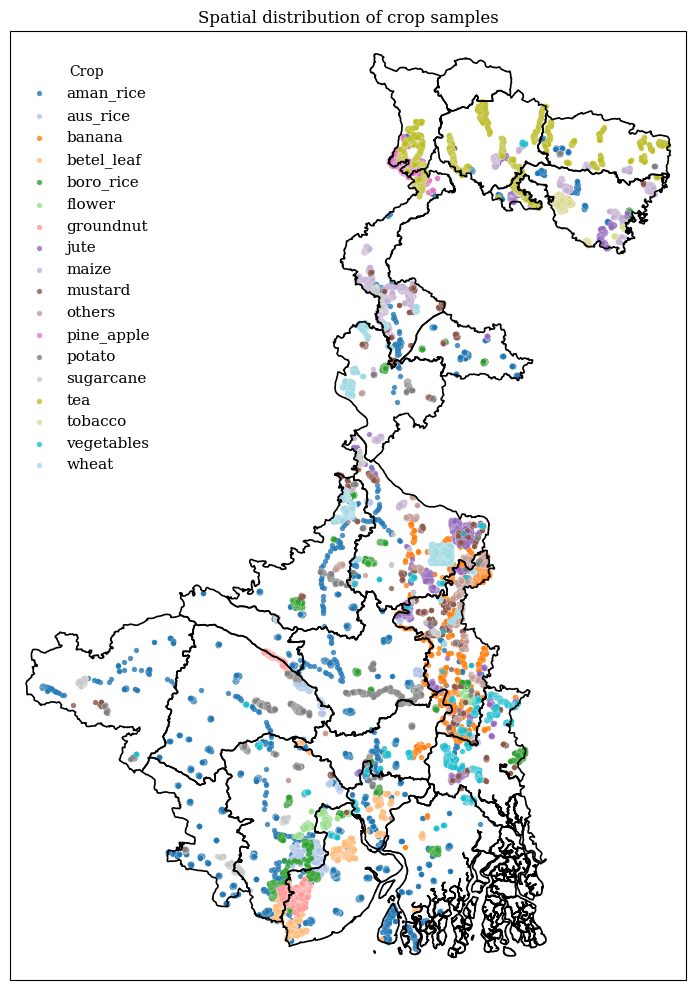

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Remove rows with missing spatial/crop data
df_plot = final_data.dropna(subset=["latitude", "longitude", "crop"])

# Ensure region is in WGS84 for Cartopy
gdf_region = wb_gdf.to_crs("EPSG:4326")

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot region boundary
ax.add_geometries(
    gdf_region.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=1.2,
)

# Set extent from region bounds (more precise than manual box)
minx, miny, maxx, maxy = gdf_region.total_bounds
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# Unique crops
crops = df_plot["crop"].unique()

# Generate categorical colors
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, len(crops)))

# Plot crop points
for crop, color in zip(crops, colors):
    subset = df_plot[df_plot["crop"] == crop]
    ax.scatter(
        subset["longitude"],
        subset["latitude"],
        transform=ccrs.PlateCarree(),
        label=crop,
        s=15,
        alpha=0.8,
        color=color,
        edgecolors="white",
        linewidths=0.1,
    )

minx, miny, maxx, maxy = gdf_region.total_bounds

x_pad = (maxx - minx) * 0.025
y_pad = (maxy - miny) * 0.025

ax.set_extent(
    [minx - x_pad, maxx + x_pad, miny - y_pad, maxy + y_pad], crs=ccrs.PlateCarree()
)

# Legend outside
ax.legend(
    loc="center left",
    bbox_to_anchor=(0, 0.75),
    frameon=False,
    title="Crop",
    fontsize=11,
)

plt.title("Spatial distribution of crop samples")
plt.tight_layout()
plt.show()